# Proyecto Telecomunicaciones

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

En este análisis se solicita:

1. Llevar a cabo el análisis exploratorio de datos

2. Identificar operadores ineficaces y

3. Probar las hipótesis estadísticas

## 1. Llevar a cabo el análisis exploratorio de datos

### Paso 1. Abrir el archivo de datos y leer la información general

In [1]:
# Primero vamos a cargar las paqueterías necesarias.

#Para trabajar los DF, importaremos "Pandas"

import pandas as pd 
from IPython.display import display

#Para las graficas:

from matplotlib import pyplot as plt
from plotly import graph_objects as go
import seaborn as sns 

#Para las pruebas de hipótesis:
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
from scipy import stats as st
import pandas as pd


#Para otros cálculos
import numpy as np

In [2]:
# Ahora vamos a cargar los dataset:

df_info = pd.read_csv('/datasets/telecom_dataset_us.csv')

df_clients = pd.read_csv('/datasets/telecom_clients_us.csv')

### Paso 2. Preparar los datos para el análisis

In [3]:
# Ahora vamos a analizar el df_info:
df_info.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 11.1 MB


Este DF tiene 9 columnas, 53,902 registros. la columna date, tiene el tipo de dato como "object" vamos a cambiarlo al tipo de dato de pandas, el resto de las columnas tienen el tipo de dato correcto

In [4]:
#Vamos a cambiar el tipo de dato de la columna date:

df_info['date'] = pd.to_datetime(df_info['date'])

df_info['date'] =  df_info['date'].dt.strftime('%Y-%m-%d')

df_info.head(5)


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,NaN,True,2,0,4
1,166377,2019-08-05,out,True,880022.0,True,3,0,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1
3,166377,2019-08-05,out,True,880020.0,False,1,10,18
4,166377,2019-08-05,out,False,880022.0,True,3,0,25


In [5]:
#Ahora vamos a ver que no existan filas duplicadas:

(df_info.duplicated().sum())

4900

In [6]:
#Hay 4,900 filas duplicadas, vamos a eliminarlas usando el método drop_duplicates:

df_info.drop_duplicates(inplace = True)

#Vamos a revisar nuevamente los duplicados:

(df_info.duplicated().sum())

0

In [7]:
# Ahora vamos a trabajar los valores nulos de las columnas "internal y operator_id:

df_info['internal'].fillna('Otro', inplace=True)
df_info['operator_id'].fillna('-', inplace=True)

#Este df, ya no tiene datos duplicados, ni nulos, está listo para ser analizado.

In [8]:
# Ahora vamos a analizar el df_clients:

df_clients.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 95.2 KB


Este df, tiene 3 columnas, con 732 filas, no tiene valores nulos, el tipo de dato de las columnas user_id y tariff_plan es correcto, pero vamos a cambiar el tipo de dato de la columna "date_start"

In [9]:
#Vamos a cambiar el tipo de dato de la columna date_start:

df_clients['date_start'] = pd.to_datetime(df_clients['date_start'])

df_clients['date_start'] =  df_clients['date_start'].dt.strftime('%Y-%m-%d')

df_clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [10]:
#Ahora vamos a ver que no existan filas duplicadas:

(df_clients.duplicated().sum())

0

Este df, no tiene datos duplicados, está listo para ser analizado.

## Identificar operadores ineficaces 

Se considera que un operador es ineficaz si: 

1. Tiene una gran cantidad de llamadas entrantes perdidas (internas y externas),

2. Tiene un tiempo de espera prolongado para las llamadas entrantes,

3. Tiene un número reducido de llamadas salientes.

In [11]:
#Vamos a revisar cada una de las consideraciones:

# 1.Tiene una gran cantidad de llamadas entrantes perdidas (internas y externas),

#Para esta consideración, vamos a contar el número de llamadas perdidas, vamos a agrupar el df por "is_missed_call":

df_mis_cal = df_info.pivot_table(
                                index='operator_id',
                                columns='is_missed_call',
                                values='calls_count',
                                aggfunc='count',
                                margins=True, 
                                margins_name='Total'
                                )


df_mis_cal

is_missed_call,False,True,Total
operator_id,,,
879896.0,70.0,47.0,117
879898.0,138.0,89.0,227
880020.0,14.0,6.0,20
880022.0,41.0,29.0,70
880026.0,95.0,87.0,182
...,...,...,...
972460.0,4.0,3.0,7
973120.0,1.0,1.0,2
973286.0,1.0,NaN,1


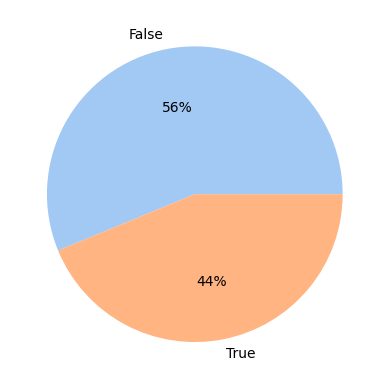

In [12]:
#Vemos que se contestan la mayoría de las llamadas, sin embargo la cantidad de llamadas perdidas es del orden del 40%...
#Vamos a graficar esta proporción:

#primero haremos el df que sólo nos muestre el numero de llamadas (perdidas y tomadas)
df_pie = df_info.groupby('is_missed_call')['calls_count'].count().reset_index()

#Ahora hacemos la gráfica:
colors = sns.color_palette('pastel')[0:4]
plt.pie(df_pie['calls_count'], labels=df_pie['is_missed_call'], colors=colors, autopct='%.0f%%')
plt.show()

Con la visualización anterior podemos ver que el 44% de las llamadas se pierden, por lo que podemos decir que este es un punto negativo para los operadores. Ya que la premisa es que es ineficaz si "tiene una gran cantidad de llamadas perdidas" y en este caso tendrían una efectividad del 56%, lo que es bajo.

In [13]:
#Ahora vamos a identificar a los operadores que cumplen con este primer punto:

#En el df_mis_cal vamos a agregar una columna para tener el "%" de llamadas perdidas:

#Pero primero vamos a cambiarle el nombre a las columnas:

df_mis_cal.columns = ['Received', 'missed', 'Total']

df_mis_cal['%_mis'] = df_mis_cal['missed']/df_mis_cal['Total']*100 

In [14]:
#Ahora vamos a filtrar a todos los operadores que tienen más del 70% de llamadas perdidas:

df_70 = df_mis_cal[df_mis_cal['%_mis']>=70]

df_70.sort_values(by= '%_mis', ascending = False).reset_index()


,operator_id,Received,missed,Total,%_mis
0,937770.0,NaN,1.0,1,100.000000
1,962904.0,NaN,1.0,1,100.000000
2,969262.0,NaN,1.0,1,100.000000
3,937710.0,NaN,1.0,1,100.000000
4,937716.0,NaN,1.0,1,100.000000
5,883018.0,NaN,1.0,1,100.000000
6,937772.0,NaN,1.0,1,100.000000
7,937778.0,NaN,1.0,1,100.000000
8,937872.0,NaN,1.0,1,100.000000
9,954284.0,NaN,1.0,1,100.000000


In [15]:
#Vamos a eliminar a los que no tienen llamadas recibidas:

df_70_ok = df_70[df_70['%_mis'] < 100].sort_values(by = '%_mis' , ascending = False).reset_index()

df_70_ok

,operator_id,Received,missed,Total,%_mis
0,-,113.0,7343.0,7456,98.484442
1,881278.0,1.0,7.0,8,87.500000
2,898434.0,1.0,5.0,6,83.333333
3,937650.0,1.0,5.0,6,83.333333
4,953460.0,1.0,5.0,6,83.333333
5,913868.0,1.0,3.0,4,75.000000
6,933452.0,1.0,3.0,4,75.000000
7,937870.0,1.0,3.0,4,75.000000
8,939718.0,1.0,3.0,4,75.000000
9,947480.0,1.0,3.0,4,75.000000


Estas 9 personas serían los operadores más ineficaces de este 1er punto.

In [16]:
#Ahora vamos a analizar la consideración N.2: Tiene un tiempo de espera prolongado para las llamadas entrantes.

#Para este punto vamos a considerar lo siguiente:

# `call_duration`: duración de la llamada (sin incluir el tiempo de espera)
# `total_call_duration`: duración de la llamada (incluido el tiempo de espera)

#Por lo que vamos a crear una columna que sea la resta de estos 2 indicadores:

df_info['t_wait'] = df_info['total_call_duration'] - df_info['call_duration']

df_info['t_wait'].median()


55.0

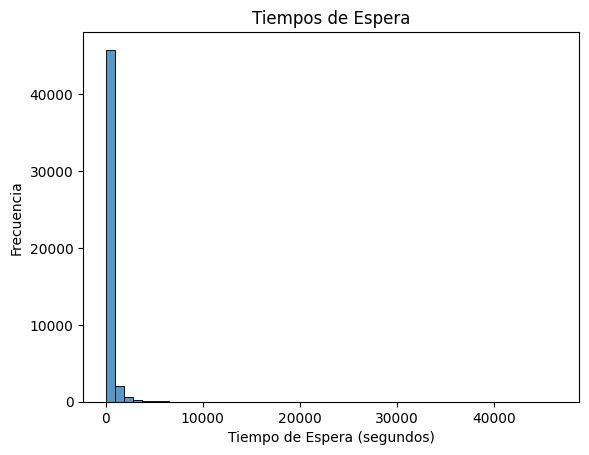

In [17]:
#Ahora vamos a graficar un histograma para ver cuanto tiempo esperan los clientes antes de que contesten sus llamadas:

sns.histplot(df_info['t_wait'], bins= 50)
plt.title('Tiempos de Espera')
plt.xlabel('Tiempo de Espera (segundos)')
plt.ylabel('Frecuencia')
plt.show()

En esta visualización podemos ver que la mayoría de los datos están pegados al "0". Adicional comentar que se calculó el valor de la mediana, la cual es de 55 segundos, por lo que podemos comprobar que los clientes esperan menos de 1 minuto en ser atendidos. Este es un punto bueno para los operadores ya que el tiempo de espera es relativamente corto.

In [18]:
#Ahora vamos a identificar a los operadores que cumplen con este segundo punto:

#Vamos a agrupar el df por operator_id y vamos a promediar sus tiempos de espera:

waiting_time = df_info.groupby('operator_id')['t_wait'].median().sort_values( ascending = False).reset_index()

#Ahora considerando que la mediana del df es de 55 segundos, vamos a filtrar a los operadores que estén 5 veces por arriba
#de este estandar (275):

waiting_time_5 = waiting_time[waiting_time['t_wait']> 275].sort_values(by = 't_wait', ascending = False).reset_index()

waiting_time_5

,index,operator_id,t_wait
0,0,885890.0,4525.0
1,1,929428.0,3030.0
2,2,925922.0,3007.0
3,3,908640.0,2885.0
4,4,919364.0,2784.0
...,...,...,...
147,147,947652.0,304.5
148,148,947604.0,303.0
149,149,943050.0,295.0
150,150,919552.0,281.0


Estas 152 personas, son las que tienen tiempos de espera más altos.

In [19]:
#Ahora vamos a analizar la consideración N.3: Tiene un número reducido de llamadas salientes:

#Para esto vamos a agrupar el df por tipo de llamada (entrada o saliente):

df_dir = df_info.groupby('direction')['calls_count'].count().reset_index()

df_dir

,direction,calls_count
0,in,20003
1,out,28999


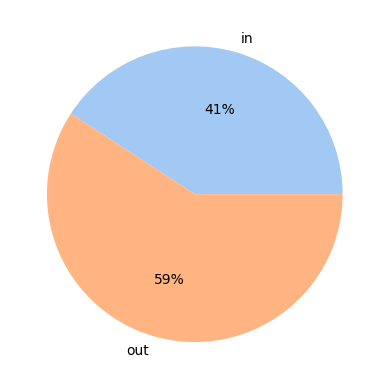

In [20]:
#Vamos a hacer una gráfica de pie para visualizar este df:

colors_dir = sns.color_palette('pastel')[0:4]
plt.pie(df_dir['calls_count'], labels=df_dir['direction'], colors=colors_dir, autopct='%.0f%%')
plt.show()

El último punto considera que los operadores son ineficaces si: Tiene un número reducido de llamadas salientes, en este caso el 59% de las llamadas son salientes, por lo que no es un número reducido de llamadas, es decir; este es un punto bueno para los operadores.

In [21]:
#Ahora vamos a identificar a los operadores que cumplen con este tercer punto:

#Para esto vamos a generar una pivot table agrupando el df por operator_id y vamos a contar el tipo de llamadas:

pivot_out = df_info.pivot_table(
                                index='operator_id',
                                columns='direction',
                                values='calls_count',
                                aggfunc='count',
                                margins=True, 
                                margins_name='Total'
                                )


In [22]:
#Ahora vamos a agregar una columna con el % de llamadas salientes:

pivot_out['%_out'] = pivot_out['out'] / pivot_out['Total']*100


pivot_out.sort_values(by = 'Total', ascending = False).reset_index()


#Ahora vamos a quitar los nulos:

pivot_out.dropna(inplace=True)

#Ahora vamos a filtrar los que tengan menos del 20% de llamadas salientes 

out_20 = pivot_out[pivot_out['%_out']<=20].sort_values(by= '%_out', ascending = False).reset_index()

out_20

direction,operator_id,in,out,Total,%_out
0,930816.0,4.0,1.0,5,20.000000
1,908080.0,4.0,1.0,5,20.000000
2,935548.0,12.0,3.0,15,20.000000
3,908834.0,4.0,1.0,5,20.000000
4,949420.0,4.0,1.0,5,20.000000
5,940630.0,49.0,12.0,61,19.672131
6,944476.0,26.0,6.0,32,18.750000
7,930814.0,9.0,2.0,11,18.181818
8,919790.0,61.0,13.0,74,17.567568
9,944246.0,5.0,1.0,6,16.666667


Estas 28 personas serían las más ineficaces en este 3er punto.

In [23]:
#Ahora vamos a ver si alguna de ellas coinciden en los 3 puntos:


#Primero vamos a generar los df para cada punto considerando sólo el "operator_id" y su calificación

punto_1 = df_70_ok[['operator_id', '%_mis']].reset_index()
punto_2 = waiting_time_5[['operator_id', 't_wait']].reset_index()
punto_3 = out_20[['operator_id', '%_out']].reset_index()

#Ahora vamos a sacar un listado de los operadores:
operadores = df_info.groupby('operator_id')['calls_count'].count().reset_index()

#Ahora vamos a unir todas las tablas:

ops_inef = operadores.merge(punto_1, on= 'operator_id', how = 'left')

ops_inef2 = ops_inef.merge(punto_2, on= 'operator_id', how = 'left')

ops_inef3 = ops_inef2.merge(punto_3, on= 'operator_id', how = 'left')

ops_inef3

,operator_id,calls_count,index_x,%_mis,index_y,t_wait,index,%_out
0,879896.0,117,NaN,NaN,NaN,NaN,NaN,NaN
1,879898.0,227,NaN,NaN,126.0,393.0,NaN,NaN
2,880020.0,20,NaN,NaN,NaN,NaN,NaN,NaN
3,880022.0,70,NaN,NaN,NaN,NaN,NaN,NaN
4,880026.0,182,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1088,972412.0,5,NaN,NaN,NaN,NaN,NaN,NaN
1089,972460.0,7,NaN,NaN,NaN,NaN,NaN,NaN
1090,973120.0,2,NaN,NaN,NaN,NaN,NaN,NaN
1091,973286.0,1,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
#Vamos a sustituir todos los NaN por 0:

ops_inef3['%_mis'].fillna('0', inplace=True)
ops_inef3['t_wait'].fillna('0', inplace=True)
ops_inef3['%_out'].fillna('0', inplace=True)

ops_inef3

,operator_id,calls_count,index_x,%_mis,index_y,t_wait,index,%_out
0,879896.0,117,NaN,0,NaN,0,NaN,0
1,879898.0,227,NaN,0,126.0,393.0,NaN,0
2,880020.0,20,NaN,0,NaN,0,NaN,0
3,880022.0,70,NaN,0,NaN,0,NaN,0
4,880026.0,182,NaN,0,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...
1088,972412.0,5,NaN,0,NaN,0,NaN,0
1089,972460.0,7,NaN,0,NaN,0,NaN,0
1090,973120.0,2,NaN,0,NaN,0,NaN,0
1091,973286.0,1,NaN,0,NaN,0,NaN,0


In [25]:
#Vamos a sumar las columnas

#Primero vamos a cambiar el tipo de dato a float:

ops_inef3['%_mis'] = ops_inef3['%_mis'].astype(float)
ops_inef3['t_wait'] = ops_inef3['t_wait'].astype(float)
ops_inef3['%_out'] = ops_inef3['%_out'].astype(float)

ops_inef3['filtro'] = ops_inef3['%_mis']+ops_inef3['t_wait']+ops_inef3['%_out']

ops_inef3

,operator_id,calls_count,index_x,%_mis,index_y,t_wait,index,%_out,filtro
0,879896.0,117,NaN,0.000000,NaN,0.0,NaN,0.000000,0.000000
1,879898.0,227,NaN,0.000000,126.0,393.0,NaN,0.000000,393.000000
2,880020.0,20,NaN,0.000000,NaN,0.0,NaN,0.000000,0.000000
3,880022.0,70,NaN,0.000000,NaN,0.0,NaN,0.000000,0.000000
4,880026.0,182,NaN,0.000000,NaN,0.0,NaN,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
1088,972412.0,5,NaN,0.000000,NaN,0.0,NaN,0.000000,0.000000
1089,972460.0,7,NaN,0.000000,NaN,0.0,NaN,0.000000,0.000000
1090,973120.0,2,NaN,0.000000,NaN,0.0,NaN,0.000000,0.000000
1091,973286.0,1,NaN,0.000000,NaN,0.0,NaN,0.000000,0.000000


In [26]:
#Ahora vamos a filtrar todos los operator_id que sean mayor a 0:

ops_ineficaces = ops_inef3[ops_inef3['filtro']>0].sort_values(by = 'filtro', ascending = False).reset_index()

ops_ineficaces

,level_0,operator_id,calls_count,index_x,%_mis,index_y,t_wait,index,%_out,filtro
0,29,885890.0,253,NaN,0.0,0.0,4525.0,NaN,0.000000,4525.000000
1,583,929428.0,65,NaN,0.0,1.0,3030.0,NaN,0.000000,3030.000000
2,551,925922.0,73,NaN,0.0,2.0,3007.0,NaN,0.000000,3007.000000
3,317,908640.0,43,NaN,0.0,3.0,2885.0,NaN,0.000000,2885.000000
4,448,919364.0,41,NaN,0.0,4.0,2784.0,NaN,0.000000,2784.000000
...,...,...,...,...,...,...,...,...,...,...
181,323,909134.0,70,NaN,0.0,NaN,0.0,21.0,7.142857,7.142857
182,379,914256.0,16,NaN,0.0,NaN,0.0,22.0,6.250000,6.250000
183,385,914440.0,20,NaN,0.0,NaN,0.0,24.0,5.000000,5.000000
184,263,905862.0,38,NaN,0.0,NaN,0.0,25.0,2.631579,2.631579


Estas 186 personas son las que tienen al menos 1 de los 3 criterios para considerarse ineficaces.

## Probar las hipótesis estadísticas

En esta parte vamos a considerar que los criterios para determinar que un operador es ineficaz, serán las hipótesis que vamos a probar:

In [27]:
# Hipótesis 1: Un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas)

#Vamos a ocupar el df que habíamos calculado, para las llamadas perdidas, pero primero vamos a quitar todos los registros 
#que no tengan llamas recibidas:

df_mis_cal_ok = df_mis_cal[df_mis_cal['Received'] != 'NaN']


In [28]:
# Vamos a definir el umbral en 70%
threshold = df_mis_cal_ok['%_mis'].quantile(0.70)
ops_inef_cr1 = df_mis_cal_ok[df_mis_cal_ok['%_mis'] >= threshold]
ops_efic_cr1 = df_mis_cal_ok[df_mis_cal_ok['%_mis'] < threshold]

alpha = 0.05

# Realizar el test de proporciones
count = [len(ops_inef_cr1), len(ops_efic_cr1)]
nobs = [len(df_mis_cal_ok), len(df_mis_cal_ok)]
stat, p_value = proportions_ztest(count, nobs)

print(f'Z-statistic: {stat}, P-value: {p_value}')

Z-statistic: -15.265421398467698, P-value: 1.2998538956756995e-52


Dado que P-value es mucho menor que el valor de alpha, podremos rechazar la hipótesis nula ya que hay una diferencia significativa entre las proporciones que estamos comparando. Es decir podemos afirmar que los operadores con una gran cantidad de llamadas perdidas, son ineficaces.


In [29]:
# Hipótesis 2: Un operador ineficaz, tiene un tiempo de espera prolongado para las llamadas entrantes.

#Vamos a usar el df que habíamos calculado para ver el tiempo de espera:

waiting_time.head()


,operator_id,t_wait
0,885890.0,4525.0
1,929428.0,3030.0
2,925922.0,3007.0
3,908640.0,2885.0
4,919364.0,2784.0


In [30]:
# Vamos a definir el umbral en 30%
threshold = waiting_time['t_wait'].quantile(0.70)
ops_inef_cr2 = waiting_time[waiting_time['t_wait'] >= threshold]
ops_efic_cr2 = waiting_time[waiting_time['t_wait'] < threshold]

alpha = 0.05

# Tiempos de espera
inef_times = ops_inef_cr2['t_wait']
efic_times = ops_efic_cr2['t_wait']

# Realizar T-test
t_stat, p_value = ttest_ind(inef_times, efic_times)

print(f'T-statistic: {t_stat}, P-value: {p_value}')


T-statistic: 22.46510469492345, P-value: 3.617151414641913e-92


Dado que P-value es mucho menor que el valor de alpha, podremos rechazar la hipótesis nula ya que hay una diferencia significativa entre loa segmentos que estamos comparando. Es decir podemos afirmar que los operadores con un tiempo de espera entre cada llamada son ineficaces.

In [31]:
# Hipótesis 3: Un operador ineficaz, si tiene un número reducido de llamadas salientes,

#Vamos a usar el df que habíamos calculado para ver las llamadas salientes

pivot_out.head()

direction,in,out,Total,%_out
operator_id,,,,
879896.0,21.0,96.0,117,82.051282
879898.0,57.0,170.0,227,74.889868
880020.0,7.0,13.0,20,65.000000
880022.0,8.0,62.0,70,88.571429
880026.0,18.0,164.0,182,90.109890


In [32]:
# Vamos a definir el umbral en 70%
threshold = pivot_out['%_out'].quantile(0.70)
ops_inef_cr3 = pivot_out[pivot_out['%_out'] >= threshold]
ops_efic_cr3 = pivot_out[pivot_out['%_out'] < threshold]

alpha = 0.05

# Realizar el test de proporciones
count = [len(ops_inef_cr3), len(ops_efic_cr3)]
nobs = [len(pivot_out), len(pivot_out)]
stat, p_value = proportions_ztest(count, nobs)

print(f'Z-statistic: {stat}, P-value: {p_value}')

Z-statistic: -13.193960212179892, P-value: 9.5057411369409e-40


Dado que P-value es mucho menor que el valor de alpha, podremos rechazar la hipótesis nula ya que hay una diferencia significativa entre las proporciones que estamos comparando. Es decir podemos afirmar que los operadores con un número reducido de llamadas salientes, son ineficaces.